In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchtext.vocab import GloVe

In [2]:
glove = GloVe(name='6B', dim=100)

# Define the tokens you want to add
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
EOS_TOKEN = '<eos>'

# Create new embeddings for the tokens and concatenate them with the GloVe embeddings
pad_embedding = torch.zeros((1, glove.dim))
unk_embedding = torch.randn((1, glove.dim))
sos_embedding = torch.randn((1, glove.dim))

new_embeddings = torch.cat([glove.vectors, pad_embedding, unk_embedding, sos_embedding], dim=0)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                               
100%|█████████▉| 399999/400000 [00:16<00:00, 23964.49it/s]


In [3]:
# Create the embedding layer and load the embeddings
embedding = nn.Embedding.from_pretrained(new_embeddings, freeze=True)

In [4]:
type(embedding)

torch.nn.modules.sparse.Embedding

In [5]:
from datasets import load_dataset

sst = load_dataset("sst", "default")

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
import re
from collections import Counter
from nltk.tokenize import word_tokenize

sentences = sst['train']['sentence']
token_counts = Counter()

for sentence in sentences:
    tokens = re.findall(r'\w+|[.-/]', sentence)
#     tokens = word_tokenize(sentence.lower())
    token_counts.update(tokens)

vocab = set(token_counts.keys())
vocab_size = len(vocab)

# Special tokens
unk_token = '<unk>'
pad_token = '<pad>'
eos_token = '<eos>'

# Check if the special tokens are in the vocabulary
if unk_token not in vocab:
    vocab_size += 1
if pad_token not in vocab:
    vocab_size += 1
if eos_token not in vocab:
    vocab_size += 1

vocab_size

17050

In [7]:
# Extract the sentences column
sentences_train = sst['train']['sentence']
sentences_val = sst['validation']['sentence']

word_to_idx = {word: i for i, word in enumerate(glove.itos)}

In [8]:
new_embeddings = torch.randn(vocab_size, 100)

In [9]:
word2idx = {word: i for i, word in enumerate(vocab)}
word2idx['<unk>'] = len(word2idx)
word2idx['<eos>'] = len(word2idx)
word2idx['<pad>'] = len(word2idx)

In [10]:
word2idx['<pad>']

17049

In [11]:
word_to_idx['unk']

201534

In [12]:
import pickle

# Save the word2idx dictionary
with open('word2idx_sst.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
# Load the saved word2idx dictionary
with open('word2idx_nli.pickle', 'rb') as handle:
    word2idx = pickle.load(handle)

In [16]:
# Train the model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
for word in vocab:
    if word.lower() in word_to_idx:
        idx = word_to_idx[word.lower()]
    else:
        idx = word_to_idx['unk']
    word_embedding = embedding(torch.tensor(idx))
    new_embeddings[word2idx[word]] = word_embedding

In [18]:
new_embeddings.shape

torch.Size([17050, 100])

In [19]:
torch.save(new_embeddings, 'new_embeddings_sst.pt')

In [20]:
new_embeddings = torch.load('new_embeddings_sst.pt')

In [21]:
import torch
from torch.utils.data import Dataset

class SSTDataset(Dataset):
    def __init__(self, sentences, word_to_idx, max_len):
        self.sentences = sentences
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tokens = sentence.strip().split()
        while(len(tokens)<self.max_len):
            tokens.append('<pad>')
        input_tokens = [self.word_to_idx.get(token.lower(), self.word_to_idx['<unk>']) for token in tokens]
        target_tokens = input_tokens[1:] + [self.word_to_idx['<eos>']]
        return torch.LongTensor(input_tokens), torch.LongTensor(target_tokens)


In [22]:
# Create the training and validation datasets
train_dataset = SSTDataset(sentences_train, word2idx, 60)
val_dataset = SSTDataset(sentences_val, word2idx, 60)

In [23]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout):
        super(ELMo, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(new_embeddings, freeze=True, sparse=True)
        self.hidden_size = embedding_dim//2
        self.lstm1 = nn.LSTM(input_size=embedding_dim,
                             hidden_size=embedding_dim//2,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True,
                             dropout=dropout
                            )
        self.lstm2 = nn.LSTM(input_size=embedding_dim,
                             hidden_size=embedding_dim//2,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True,
                             dropout=dropout)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        self.gamma = nn.Parameter(torch.ones(1))
        self.weights = [0.2, 0.4, 0.4]

    def forward(self, x):
        embeds = self.embedding(x)  # shape: (batch_size, max_seq_length, embedding_dim)

        lstm1_out, _ = self.lstm1(embeds)  # shape: (batch_size, max_seq_length, hidden_size*2)
        lstm2_out, _ = self.lstm2(lstm1_out)  # shape: (batch_size, max_seq_length, hidden_size*2)
        output = self.fc(lstm2_out)  # shape: (batch_size, max_seq_length, vocab_size)
        
        elmo_embeddings = self.gamma * (self.weights[0]*embeds + self.weights[1]*lstm1_out + self.weights[2]*lstm2_out) # shape: (batch_size, max_seq_length, 2*hidden_size)

        return output, elmo_embeddings


In [24]:
sst['train']['sentence'][:10]

["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 "The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .",
 'Singer\\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .',
 "You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .",
 'Yet the act is still charming here .',
 "Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .",
 'Just the labour involved in creating the layered ri

In [25]:
for a in train_dataset:
    print(a)
    break

(tensor([ 6022, 11163, 13148,  2539, 10844, 11639,  6022,  6653,  7066, 17047,
         4522, 17047, 17047, 17047,  6541,  4277, 13572, 17047, 13332, 10844,
        10727,  3482, 16115, 11655, 10153,   580, 17047, 17047, 17047, 17047,
         2142, 17047,  7445, 17047, 17047, 10064, 17049, 17049, 17049, 17049,
        17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049,
        17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049]), tensor([11163, 13148,  2539, 10844, 11639,  6022,  6653,  7066, 17047,  4522,
        17047, 17047, 17047,  6541,  4277, 13572, 17047, 13332, 10844, 10727,
         3482, 16115, 11655, 10153,   580, 17047, 17047, 17047, 17047,  2142,
        17047,  7445, 17047, 17047, 10064, 17049, 17049, 17049, 17049, 17049,
        17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049,
        17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17049, 17048]))


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

# Hyperparameters
VOCAB_SIZE = vocab_size
EMBEDDING_DIM = 100
# HIDDEN_SIZE = 512
DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 50

# Create model, optimizer, and loss function
# model = ELMo(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, DROPOUT)
model = ELMo(VOCAB_SIZE, EMBEDDING_DIM, DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
for i, (inputs, targets) in enumerate(train_loader):
    print(targets.squeeze())
    print(inputs.shape)
    break

tensor([[17047, 17047,  8790,  ..., 17049, 17049, 17048],
        [17047,  4239,  3482,  ..., 17049, 17049, 17048],
        [ 1313, 13148,  3482,  ..., 17049, 17049, 17048],
        ...,
        [17047, 13148,  9331,  ..., 17049, 17049, 17048],
        [ 2995, 16102, 10844,  ..., 17049, 17049, 17048],
        [ 3506, 17047,  1776,  ..., 17049, 17049, 17048]])
torch.Size([32, 60])


In [29]:
# 0.14
losses = []
model.to(device)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs[0].view(-1, vocab_size)
        targets = targets.view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % BATCH_SIZE == 0:
            losses.append(running_loss / BATCH_SIZE)
            running_loss = 0.0
        
        
    print('[Epoch %d, Batch %5d] loss: %.3f' %
            (epoch+1, i+1, running_loss / BATCH_SIZE))
    running_loss = 0.0

print('Finished Training')


[Epoch 1, Batch   267] loss: 1.851
[Epoch 2, Batch   267] loss: 1.576
[Epoch 3, Batch   267] loss: 1.358
[Epoch 4, Batch   267] loss: 1.225
[Epoch 5, Batch   267] loss: 1.104
[Epoch 6, Batch   267] loss: 0.988
[Epoch 7, Batch   267] loss: 0.916
[Epoch 8, Batch   267] loss: 0.796
[Epoch 9, Batch   267] loss: 0.726
[Epoch 10, Batch   267] loss: 0.691
[Epoch 11, Batch   267] loss: 0.615
[Epoch 12, Batch   267] loss: 0.562
[Epoch 13, Batch   267] loss: 0.509
[Epoch 14, Batch   267] loss: 0.462
[Epoch 15, Batch   267] loss: 0.424
[Epoch 16, Batch   267] loss: 0.361
[Epoch 17, Batch   267] loss: 0.340
[Epoch 18, Batch   267] loss: 0.304
[Epoch 19, Batch   267] loss: 0.274
[Epoch 20, Batch   267] loss: 0.257
[Epoch 21, Batch   267] loss: 0.223
[Epoch 22, Batch   267] loss: 0.194
[Epoch 23, Batch   267] loss: 0.182
[Epoch 24, Batch   267] loss: 0.145
[Epoch 25, Batch   267] loss: 0.143
[Epoch 26, Batch   267] loss: 0.115
[Epoch 27, Batch   267] loss: 0.107
[Epoch 28, Batch   267] loss: 0.095
[

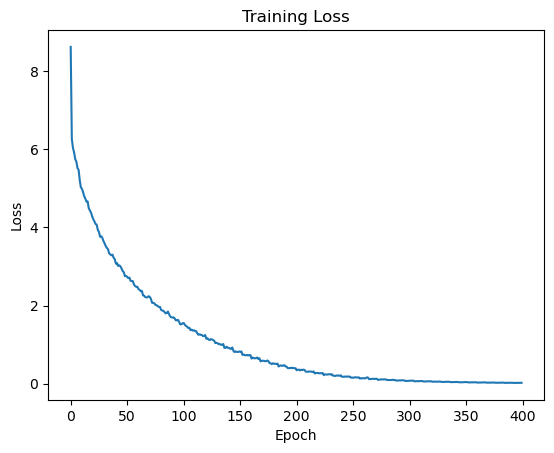

Final Training Loss: 0.0215792813396547


In [30]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Final Training Loss:', losses[-1])

In [31]:
torch.save(model.state_dict(), 'elmo_model_sst.pt')

In [32]:
model.load_state_dict(torch.load('elmo_model_sst.pt'))

<All keys matched successfully>

In [33]:
import torch
from nltk.tokenize import word_tokenize

# Define a function to convert a sentence to a tensor of word indices
def sentence_to_tensor(sentence, word2idx):
    tokens = word_tokenize(sentence.lower())
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    tensor = torch.LongTensor(indices).unsqueeze(0)  # add batch dimension
    return tensor

# Define a function to get the ELMo embeddings of a sentence
def get_elmo_embeddings(sentence, model, word2idx):
    with torch.no_grad():
        # Convert the sentence to a tensor of word indices
        inputs = sentence_to_tensor(sentence, word2idx)
        
        # Get the ELMo embeddings
        _, elmo_embeddings = model(inputs.to(device))
        
        # Remove the batch dimension
        elmo_embeddings = elmo_embeddings.squeeze(0)
        
        return elmo_embeddings
    
# Define a function to convert a sentence to a tensor of word indices
def sentence_to_tensor_padded(sentence, word2idx, pad):
    tokens = word_tokenize(sentence.lower())
    while(len(tokens)<pad):
        tokens.append('<pad>')
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    tensor = torch.LongTensor(indices).unsqueeze(0)  # add batch dimension
    return tensor
    
# Define a function to get the ELMo embeddings of a sentence
def get_elmo_embeddings_padded(sentence, model, word2idx, pad):
    with torch.no_grad():
        # Convert the sentence to a tensor of word indices
        inputs = sentence_to_tensor_padded(sentence, word2idx, pad)
        
        # Get the ELMo embeddings
        _, elmo_embeddings = model(inputs.to(device))
        
        # Remove the batch dimension
        elmo_embeddings = elmo_embeddings.squeeze(0)
        
        return elmo_embeddings


In [34]:
# Define a sentence
sentence = "I love pizza"
sentence2 = "I love pasta"
 
# Get the ELMo embeddings of the sentence
elmo_embeddings = get_elmo_embeddings(sentence, model, word2idx)
elmo_embeddings2 = get_elmo_embeddings(sentence2, model, word2idx)

In [35]:
print(elmo_embeddings.shape)

torch.Size([3, 100])


In [36]:
sst['train']['sentence'][1]

"The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth ."

In [37]:
get_elmo_embeddings(sst['train']['sentence'][1], model, word2idx).shape

torch.Size([38, 100])

In [38]:
sst['train']['label'][1]

0.833329975605011

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [41]:
class SentimentDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


In [111]:
sst

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})

In [42]:
data = []
labels = []
for i, sentence in enumerate(sst['train']['sentence']):
    data.append(get_elmo_embeddings_padded(sentence, model, word2idx, 60).float())
    labels.append(sst['train']['label'][i])

In [43]:
word2idx['<pad>']

17049

In [44]:
sst_train_dataset = SentimentDataset(data, labels)
sst_train_loader = DataLoader(sst_train_dataset, batch_size=32, shuffle=True)

In [45]:
data = []
labels = []
for i, sentence in enumerate(sst['validation']['sentence']):
    data.append(get_elmo_embeddings_padded(sentence, model, word2idx, 60).float())
    labels.append(sst['validation']['label'][i])

In [46]:
sst_val_dataset = SentimentDataset(data, labels)
sst_val_loader = DataLoader(sst_val_dataset, batch_size=32, shuffle=True)

In [47]:
data = []
labels = []
for i, sentence in enumerate(sst['test']['sentence']):
    data.append(get_elmo_embeddings_padded(sentence, model, word2idx, 60).float())
    labels.append(sst['test']['label'][i])
    
sst_test_dataset = SentimentDataset(data, labels)
sst_test_loader = DataLoader(sst_test_dataset, batch_size=32, shuffle=True)

In [48]:
sst_train_loader

In [49]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x) # lstm_out shape: (seq_len, batch, hidden_size)
        output = self.fc(h_n[-1]) # using the hidden state of the last time step to make the final output
        output = self.fc2(output)
        output = self.fc3(output)
        return output.view(-1) # flattening the output to a 1D tensor of shape (batch_size,)

In [50]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
hidden_size = 512
num_layers = 2
dropout = 0.5
input_size = 100
output_size = 1

In [51]:
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size, dropout)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []

lstm_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # Training
    lstm_model.train()
    for data, labels in sst_train_loader:
        optimizer.zero_grad()
        lstm_input = data.float().permute(1, 0, 2).to(device) # reshape to (seq_len, batch, input_size) and move to GPU
        outputs = lstm_model(lstm_input)
        labels = labels.float().to(device) # move labels to GPU
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    # Validation
    lstm_model.eval()
    with torch.no_grad():
        for data, labels in sst_val_loader:
            lstm_input = data.float().permute(1, 0, 2).to(device)  # reshape to (seq_len, batch, input_size) and move to GPU
            outputs = lstm_model(lstm_input)
            labels = labels.float().to(device) # move labels to GPU
            loss = criterion(outputs, labels)
            val_loss += loss.item() * data.size(0)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print epoch statistics
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/10, Train Loss: 0.0661, Val Loss: 0.0552
Epoch 2/10, Train Loss: 0.0572, Val Loss: 0.0548
Epoch 3/10, Train Loss: 0.0543, Val Loss: 0.0485
Epoch 4/10, Train Loss: 0.0512, Val Loss: 0.0488
Epoch 5/10, Train Loss: 0.0489, Val Loss: 0.0496
Epoch 6/10, Train Loss: 0.0464, Val Loss: 0.0512
Epoch 7/10, Train Loss: 0.0451, Val Loss: 0.0439
Epoch 8/10, Train Loss: 0.0426, Val Loss: 0.0649
Epoch 9/10, Train Loss: 0.0415, Val Loss: 0.0418
Epoch 10/10, Train Loss: 0.0387, Val Loss: 0.0431


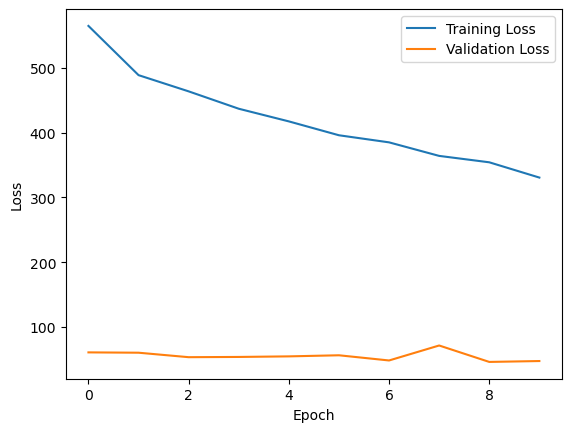

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [163]:
torch.save(lstm_model.state_dict(), 'model_sentiment.pt')

In [165]:
lstm_model.load_state_dict(torch.load('model_sentiment.pt'))

<All keys matched successfully>

In [54]:
def getSent(sent):
    inp = get_elmo_embeddings_padded(sent, model, word2idx, 60).float()
    out = outputs = lstm_model(inp)
    return out
sent = "hey hello?"
getSent(sent)

tensor([0.4980], device='cuda:0', grad_fn=<ViewBackward0>)

In [55]:
lstm_model.eval()
mse = 0.0
with torch.no_grad():
    for data, labels in sst_test_loader:
        lstm_input = data.float().permute(1, 0, 2).to(device)  # reshape to (seq_len, batch, input_size) and move to GPU
        outputs = lstm_model(lstm_input)
        labels = labels.float().to(device) # move labels to GPU
        mse += ((outputs - labels) ** 2).sum().item()  # add up the squared errors

mse /= len(sst_test_dataset)  # divide by the number of samples to get the average MSE
print(f'Test MSE: {mse:.4f}')

Test MSE: 0.0454


In [56]:
print(sst['test']['sentence'][83], sst['test']['label'][83])

Director Kapur is a filmmaker with a real flair for epic landscapes and adventure , and this is a better film than his earlier English-language movie , the overpraised Elizabeth . 0.6805599927902222


In [57]:
getSent(sst['test']['sentence'][83])

tensor([0.7201], device='cuda:0', grad_fn=<ViewBackward0>)